# Análisis y transformación de variables categóricas, clasificación y optimización (fine tuning) con redes neuronales – préstamos en instituciones bancarias

En esta práctica aprenderás a desarrollar y optimizar un clasificador mediante Redes Neuronales para predecir si un cliente en un banco es un cliente adecuado (BUENO, es decir, de bajo riesgo) o un cliente no adecuado (MALO, es decir, de alto riesgo) para concederle un crédito. Para ello, utilizaremos un Pipeline que es una herramienta que permite combinar transformadores, clasificadores, regresores u otros estimadores para construir un estimador compuesto. En el Pipeline integraremos pasos de transformación de variables y el clasificador. Además, aprenderás a evaluar y optimizar/ajustar (Tuning) los parámetros (hiperparámetros) del método mediante las funciones de cross_val_score, metrics y GridSearchCV. Finalmente, aprenderás a presentar los resultados en un Heatmap de tal manera que puedas indentificar visualmente los mejores valores de los parámetros.

En este ejemplo seguirás un proceso de análisis de datos en fases:

* Fase 1: preparación de datos
* Fase 2: entrenamiento base de una red neuronal
* Fase 3: optimización del modelo de red neuronal (Fine Tuning)
* Fase 4: predicción de nuevos samples (nuevos clientes)

## Fase 1: Preparación de datos

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt 

from time import time
from datetime import datetime, timedelta

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import load_model

from sklearn import metrics 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import set_config   

print("Módulos y clases importados")


Módulos y clases importados


Carga y descripción del dataset
Nombre del dataset: Statlog (German Credit Data). Enlace: http://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data) [7].

Descripción general: este conjunto de datos clasifica a las personas descritas por un conjunto de atributos como riesgos crediticios buenos o malos.

Número de Variables (o atributos): 21

Número de instancias (clientes en el banco): 1000

Salida: TIPOCLIENTE (BUEN CLIENTE O BAJO RIESGO:1, MAL CLIENTE O ALTO RIESGO:2)

In [2]:
nombresVariables=['ESTADOCUENTACORRIENTE','PLAZOMESESCREDITO','HISTORIALCREDITO','PROPOSITOCREDITO','MONTOCREDITO',
                  'SALDOCUENTAAHORROS','TIEMPOACTUALEMPLEO','TASAPAGO','ESTADOCIVILYSEXO','GARANTE','TIEMPORESIDENCIAACTUAL',
                  'ACTIVOS','EDAD','OTROSPLANESPAGO','VIVIENDA','CANTIDADCREDITOSEXISTENTES','EMPLEO',
                  'CANTIDADPERSONASAMANTENER','TELEFONO','TRABAJADOREXTRANJERO','TIPOCLIENTE']
#Cargar un dataframe desde una URL
dataframe = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data', sep = ' ', 
                         names=nombresVariables)
#Cargar un dataframe de un archivo local
#dataset = "Datasets/german.data"
#dataframe = pd.read_csv(dataset, sep = ' ', names=nombresVariables)

print('cantidad de observaciones (clientes): ',dataframe.shape[0])
print('cantidad de variables: ',dataframe.shape[1])
print(dataframe.shape)
dataframe.head()

cantidad de observaciones (clientes):  1000
cantidad de variables:  21
(1000, 21)


,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,...,ACTIVOS,EDAD,OTROSPLANESPAGO,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TELEFONO,TRABAJADOREXTRANJERO,TIPOCLIENTE
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### Formato a la variable de salida

In [3]:
#Se modifica la variable de salida (de estudio): TIPOCLIENTE. Es mejor tener la salida en formato binario cuando hay dos clases
dataframe['TIPOCLIENTE'] = dataframe['TIPOCLIENTE'].replace(2, 0)
dataframe.head()

,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,...,ACTIVOS,EDAD,OTROSPLANESPAGO,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TELEFONO,TRABAJADOREXTRANJERO,TIPOCLIENTE
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


### Eliminación de variables y separación de variable de salida

In [4]:
#Se separa la variable de salida "Y" para poder realizar la preparación de datos a las variables independiente "X" 
Y=dataframe['TIPOCLIENTE']
dataframe=dataframe.drop(['OTROSPLANESPAGO'], axis=1)
dataframe=dataframe.drop(['TELEFONO'], axis=1)
dataframe=dataframe.drop(['TIPOCLIENTE'], axis=1)
print(dataframe.shape)
dataframe.head()

(1000, 18)


,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,TIEMPORESIDENCIAACTUAL,ACTIVOS,EDAD,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TRABAJADOREXTRANJERO
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A152,2,A173,1,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A152,1,A173,1,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A152,1,A172,2,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A153,1,A173,2,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A153,2,A173,2,A201


### Frecuencia de Clase

<Axes: xlabel='TIPOCLIENTE', ylabel='count'>

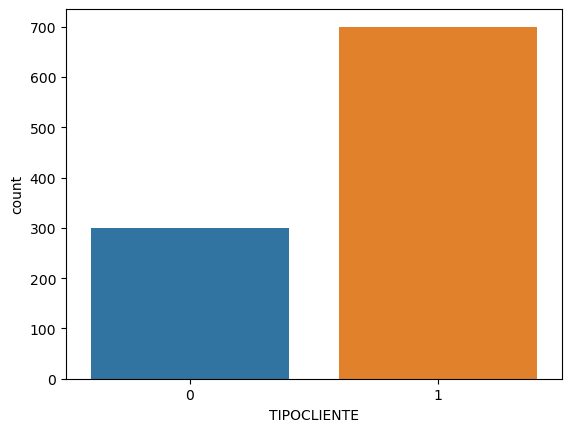

In [5]:
#Se genera una figura de frecuencia de clase, es decir, la cantidad de muestras en cada clase.
sns.countplot(x=Y)

### Análisis de variables categóricas

In [6]:
#Determinación de tipos de variables
categorical_ordinal_features = ['ESTADOCUENTACORRIENTE','HISTORIALCREDITO','SALDOCUENTAAHORROS','TIEMPOACTUALEMPLEO',
                                'ESTADOCIVILYSEXO','ACTIVOS','VIVIENDA','EMPLEO']
categorical_nominal_features = ['PROPOSITOCREDITO','GARANTE','TRABAJADOREXTRANJERO']
numeric_features = ['PLAZOMESESCREDITO','MONTOCREDITO','TASAPAGO','TIEMPORESIDENCIAACTUAL','EDAD','CANTIDADCREDITOSEXISTENTES',
                    'CANTIDADPERSONASAMANTENER']

In [7]:
def analisisVariables(dataframe, categorical_ordinal_features, categorical_nominal_features):
    cantidadTotalVariables = len(dataframe.columns) 
    print('Cantidad de variables antes de transformación de variables: ',cantidadTotalVariables)
    cantidadVariablesNominales = len(categorical_nominal_features)
    cantidadVariablesBinarias=0
    for variable in categorical_nominal_features:
        cantidadCategorias=dataframe[variable].nunique()
        cantidadVariablesBinarias=cantidadVariablesBinarias+cantidadCategorias
        print('Cantidad de categorías en la variable categórica nominal',variable,':',cantidadCategorias)
    print('Cantidad de variables binarias que reemplazarán a las variables categóricas nominales: ',cantidadVariablesBinarias)
    cantidadTotalVariablesConTransformacion = cantidadTotalVariables - cantidadVariablesNominales + cantidadVariablesBinarias
    return cantidadTotalVariablesConTransformacion

In [8]:
cantidadTotalVariablesConTransformacion=analisisVariables(dataframe, categorical_ordinal_features, categorical_nominal_features)
print('Cantidad de variables que habrá después de la transformación de variables: ',cantidadTotalVariablesConTransformacion)

Cantidad de variables antes de transformación de variables:  18
Cantidad de categorías en la variable categórica nominal PROPOSITOCREDITO : 10
Cantidad de categorías en la variable categórica nominal GARANTE : 3
Cantidad de categorías en la variable categórica nominal TRABAJADOREXTRANJERO : 2
Cantidad de variables binarias que reemplazarán a las variables categóricas nominales:  15
Cantidad de variables que habrá después de la transformación de variables:  30


cantidadVariablesBinarias = 10+3+2=15 variables binarias en total

Las 3 variables categóricas nominales serán reemplazadas por las 15 variables binarias

Por lo tanto,

A las 18 variables iniciales se eliminarán las 3 variables categóricas nominales y se agregarán las 15 variables binarias.

18-3+15=30 variables

El dataframe luego de la transformación categórica a numérica tendrá 30 variables.

### Diseño de transformadores
Por medio de un Pipeline creamos un estimador compuesto. Esta herramienta nos permite combinar preprocesadores y transformadores para llevar un orden y estructura en el proceso de transformación de variables. Para una mejor organización creamos los preprocesadores y sus métodos de transformación.

In [9]:
#Definición de transformadores (preprocesadores)

#1. Preprocesador de variables categóricas a numéricas (ordinales y nominales)
categorical_ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())])
categorical_nominal_transformer_ConNombres = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse = False, handle_unknown = "ignore"))])# se ignorará una categoría desconocida
preprocesorCategoricoNumericoConNombres = ColumnTransformer(
    transformers=[
        ('catord', categorical_ordinal_transformer, categorical_ordinal_features),
        ('catnom', categorical_nominal_transformer_ConNombres, categorical_nominal_features)
    ],remainder='passthrough',n_jobs=-1)

#2. Normalización y Scaling: Preprocesador de variables numéricas con transformación MinMaxScaler
minmax_transformer = Pipeline(steps=[
    ('minmax', MinMaxScaler(feature_range=(0, 1)))])
preprocesorMinMax = ColumnTransformer(transformers =[
    ('tranminmax', minmax_transformer, list(range(cantidadTotalVariablesConTransformacion)))
], remainder ='passthrough')

#3. Estandarización: Preprocesador de variables numéricas con transformación StandardScaler
standardscaler_transformer = Pipeline(steps=[
    ('scaler', StandardScaler(with_mean=True,with_std=True))])
preprocesorStandardScaler = ColumnTransformer(transformers =[
    ('transcaler', standardscaler_transformer, list(range(cantidadTotalVariablesConTransformacion)))
], remainder ='passthrough')

#4. Preprocesador de variables numéricas con transformación SimpleImputer
simpleimputer_transformer = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='median')) #otras: strategy='constant', strategy='most_frequent'
])
preprocesorSimpleImputer = ColumnTransformer(transformers =[
('transimpleimputer', simpleimputer_transformer, list(range(cantidadTotalVariablesConTransformacion)))
], remainder ='passthrough')

### Diseño de pipeline
El procesador ‘prepcn’ es indispensable que se aplique antes de los demás preprocesadores numéricos. En el Pipeline “pipe” se aplica primeramente la tansformación de variables categóricas a variables numéricas y en segundo lugar se aplica la transformación numérica.

In [10]:
#Construcción de Pipeline con transformadores
pipe = Pipeline(steps=[
    ('prepcn', preprocesorCategoricoNumericoConNombres), 
    ('prepstandard', preprocesorStandardScaler)
    #('prepminmax', preprocesorMinMax)
])

### Transformación de variables

In [11]:
#Se ejecuta el pipeline
dataframeTransformado=copy.deepcopy(dataframe)
X_Transformado = pipe.fit_transform(dataframeTransformado)
print('********** Pipeline aplicado')
print('********** Transformador categórico nominal:')
print(pipe.named_steps['prepcn'].transformers_[1])
#Formación de dataframe transformado
cnamesDataset1=[]
if len(categorical_ordinal_features)!=0:
    cnamesDataset1.extend(categorical_ordinal_features)
if len(categorical_nominal_features)!=0:
    #nos ubicamos primeramente en el paso "prepcn" 
    #luego, en el transformador "catnom" que está en [1] y luego en "onehot", por eso [1][1] 
    cnamesDataset2 = pipe.named_steps['prepcn'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_nominal_features)
    cnamesDataset1.extend(cnamesDataset2)
cnamesDataset3 = numeric_features
cnamesDataset1.extend(cnamesDataset3)
print('********** Cantidad de variables:', len(cnamesDataset1))
print('********** Lista de variables:')
print(cnamesDataset1)
dataframeTransformado = pd.DataFrame(data=X_Transformado,columns=cnamesDataset1)
#Guardar el dataset sin etiquetas como csv
dataframeTransformado.to_csv("DatasetTransformadoSinEtiquetas.csv", sep=";",index = False)
#Se agrega la variable de salida (etiquetas) al final
dataframeTransformado = pd.concat([dataframeTransformado, Y], axis = 1)
#Guardar el dataset con etiquetas como csv
dataframeTransformado.to_csv("DatasetTransformadoConEtiquetas.csv", sep=";",index = False)
dataframeTransformado.head()

********** Pipeline aplicado
********** Transformador categórico nominal:
('catnom', Pipeline(steps=[('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse=False,
                               sparse_output=False))]), ['PROPOSITOCREDITO', 'GARANTE', 'TRABAJADOREXTRANJERO'])
********** Cantidad de variables: 30
********** Lista de variables:
['ESTADOCUENTACORRIENTE', 'HISTORIALCREDITO', 'SALDOCUENTAAHORROS', 'TIEMPOACTUALEMPLEO', 'ESTADOCIVILYSEXO', 'ACTIVOS', 'VIVIENDA', 'EMPLEO', 'PROPOSITOCREDITO_A40', 'PROPOSITOCREDITO_A41', 'PROPOSITOCREDITO_A410', 'PROPOSITOCREDITO_A42', 'PROPOSITOCREDITO_A43', 'PROPOSITOCREDITO_A44', 'PROPOSITOCREDITO_A45', 'PROPOSITOCREDITO_A46', 'PROPOSITOCREDITO_A48', 'PROPOSITOCREDITO_A49', 'GARANTE_A101', 'GARANTE_A102', 'GARANTE_A103', 'TRABAJADOREXTRANJERO_A201', 'TRABAJADOREXTRANJERO_A202', 'PLAZOMESESCREDITO', 'MONTOCREDITO', 'TASAPAGO', 'TIEMPORESIDENCIAACTUAL', 'EDAD', 'CANTIDADCREDITOSEXISTENTES', 'CANTIDADPERSONASAMANTENER']


,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,ESTADOCIVILYSEXO,ACTIVOS,VIVIENDA,EMPLEO,PROPOSITOCREDITO_A40,PROPOSITOCREDITO_A41,...,TRABAJADOREXTRANJERO_A201,TRABAJADOREXTRANJERO_A202,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER,TIPOCLIENTE
0,-1.254566,1.344014,1.833169,1.338078,0.449326,-1.293723,0.133710,0.146949,-0.552705,-0.338862,...,0.196014,-0.196014,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290,1
1,-0.459026,-0.503428,-0.699707,-0.317959,-0.963650,-1.293723,0.133710,0.146949,-0.552705,-0.338862,...,0.196014,-0.196014,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290,0
2,1.132053,1.344014,-0.699707,0.510060,0.449326,-1.293723,0.133710,-1.383771,-0.552705,-0.338862,...,0.196014,-0.196014,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869,1
3,-1.254566,-0.503428,-0.699707,0.510060,0.449326,-0.341055,2.016956,0.146949,-0.552705,-0.338862,...,0.196014,-0.196014,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869,1
4,-1.254566,0.420293,-0.699707,-0.317959,0.449326,1.564281,2.016956,0.146949,1.809283,-0.338862,...,0.196014,-0.196014,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869,0


In [12]:
# Funciones para guardar y cargar un Pipeline o Modelo
def guardarPipeline(pipeline,nombreArchivo):
    with open(nombreArchivo+'.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
guardarPipeline(pipe,'pipePreprocesadores')

## Fase 2: Entrenamiento base de una red neuronal

### Carga de pipeline de preparación del conjunto de datos

Se puede cargar un Pipeline creado previamente para la preparación de los datos de este dataset.

In [14]:
def cargarPipeline(nombreArchivo):
    with open(nombreArchivo+'.pickle', 'rb') as handle:
        pipeline = pickle.load(handle)
    return pipeline

In [15]:
nombreArchivoPreprocesador='pipePreprocesadores'
pipe=None
pipe=cargarPipeline(nombreArchivoPreprocesador) #Debes incluir el archivo del Pipeline en el mismo directorio del script 
cantidadPasos=len(pipe.steps)
print("Cantidad de pasos: ",cantidadPasos)
set_config(display='diagram')
pipe

Cantidad de pasos:  2


Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('catord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['ESTADOCUENTACORRIENTE',
                                                   'HISTORIALCREDITO',
                                                   'SALDOCUENTAAHORROS',
                                                   'TIEMPOACTUALEMPLEO',
                                                   'ESTADOCIVILYSEXO',
                                                   'ACTIVOS', 'VIVIENDA',
                                                   'EMPLEO']),
                                                 ('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['PROPOSITOCREDITO',
                                                   'GARANTE',
                                                   'TRABAJADOREXTRANJERO'])])),
                ('prepstandard',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transcaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28,
                                                   29])]))])

In [16]:
#Funciones para guardar y cargar la Red Neuronal (Arquitectura y Pesos)
def guardarNN(model,nombreArchivo):
    print("Guardando Red Neuronal en Archivo")  
    model.save(nombreArchivo+'.h5')
    print("Red Neuronal Grabada en Archivo")   
    
def cargarNN(nombreArchivo):
    model = load_model(nombreArchivo+'.h5')    
    print("Red Neuronal Cargada desde Archivo") 
    return model

### Parámetros principales de una Red Neuronal

En Python con Keras para crear una Red Neuronal se requiere definir fundamentalmente los siguientes parámetros:

**epochs**: cantidad de veces (pasos) que se repite el proceso de forward y back propagation

**batch_size**: cantidad de muestras para aplicar el ajuste de pesos.

**optimizer:** es el tipo de algoritmo de descenso del gradiente que nos ayudará a determinar hacia donde mover los pesos. Optimizadores disponibles: SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam y Ftrl.

Para profundizar en Keras puedes revisar su documentación.

### Modificación de un Pipeline

En un Pipeline se puede agregar y eliminar sus elementos. Para ello, las funciones más importantes son:

**insert:** agrega un paso (step) antes del paso con el índice dado

**append:** agrega un paso al final del Pipeline

**pop:** elimina y retorna el paso con el índice dado (por defecto es el último, es decir, index=-1).

Puedes revisar las demás funciones con: help(pipe.steps)

### Creación de la Red Neuronal

A continuación, creamos la Red Neuronal. Luego, agregamos el clasificador al final del Pipeline

In [17]:
#Se identifica la cantidad de variables para crear la capa de entrada de la red neuronal
nombrePrep='prepstandard'#prepcn, prepminmax, prepstandard
cantidadVariablesIndependientes = len(pipe.named_steps[nombrePrep].transformers_[0][2])
print("\nCantidad de variables después de preprocesamiento: ",cantidadVariablesIndependientes)


Cantidad de variables después de preprocesamiento:  30


In [18]:
model = Sequential()

#La primera capa Dense recibe el numero de variables, que es la segunda dimensión del dataframe
#La primera capa tiene 3 neuronas. La función de activación es la función rectificadora.
model.add(Dense(3, input_shape=(cantidadVariablesIndependientes,), activation='relu'))
#La capa de salida tiene 1 neurona. La capa de salida debe tener la misma dimensión como de cantidad de salidas queremos,
#por ejemplo, en este caso la salida "TIPOCLIENTE" solo requiere un valor: 0 o 1, entonces 1 neurona es suficiente. 
#La función de activación es sigmoid para calcular la clasificación en términos de probabilidad.
model.add(Dense(1, activation='sigmoid'))

#Como tenemos dos posibles valores de salida "0 o 1", vamos a escoger que el error lo trate como una clasificación binaria.
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

#Se inserta el modelo como paso final del pipeline
pipe.steps.append(['modelNN',model])
#Aquí en lugar del clasificador de Red Neuronal podría ser otro modelo como un Random Forest, una SVM, etc.

#También se pudo haber insertado el modelo indicando el índice (el número de paso específico dentro del pipeline)
#pipe.steps.insert(cantidadPasos,['modelNN',model])

#Se puede eliminar un paso específico del pipeline de la siguiente manera
#pipe.steps.pop(2)

print("Cantidad de pasos: ",len(pipe.steps))

#Mostrar el resumen de la arquitectura de la red neuronal. 
pipe.named_steps['modelNN'].summary()



Cantidad de pasos:  3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 93        
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 97 (388.00 Byte)
Trainable params: 97 (388.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**“Param #”** indica la cantidad de parámetros necesarios en dicha capa para almacenar la información de los pesos y las salidas. Por ejemplo, la primera capa que consta de 30 variables de entrada y 3 neuronas, requiere 90 parámetros para las conexiones entre las entradas y las neuronas (30×3=90). A esto se suma 3 parámetros adicionales, ya que se genera 3 salidas, una por cada neurona. En total, en la primera capa se necesita 93 parámetros.

Las salidas de la primera capa son las entradas de la segunda capa. Debido a esto, la segunda consta de 3 entradas y 1 neurona, por lo cual requiere 3 parámetros (3×1=3). A esto se suma 1 parámetro adicional, ya que se genera 1 salida. En total, en la capa de salida se necesita 4 parámetros.

Y en total, en la red neuronal se requiere 97 parámetros (93+4=97).

**Sugerencias de función de activación de la última capa y de forma de predicción:**

Predicción con ‘np.argmax(model.predict(x), axis=-1)’, si el modelo realiza clasificación multi-clase. Función de activation ‘softmax’ en la última capa

Predicción con ‘(model.predict(x) > 0.5).astype(“int32”)’, si el modelo realiza clasificación binaria. Función de activation ‘sigmoid’ en la última capa

### Entrenamiento de la Red Neuronal
Para el entrenamiento y testing del modelo se genera las particiones del conjunto de datos en X_train, X_test, y_train, y_test. Convencionalmente, el 80% es para entrenamiento y el 20% es para testing. Más adelante veremos que parte del conjunto de entrenamiento se puede separar para validación (ajuste/optimización de hiperparámetros del modelo).

In [19]:
Yval=Y.values
X=copy.deepcopy(dataframe)

X_train, X_test, y_train, y_test = train_test_split(X, Yval, test_size = 0.2)#random_state = 0
pipe.fit(X_train, y_train, modelNN__epochs=10, modelNN__batch_size=50, modelNN__verbose=0)#modelNN__validation_split=0.1, modelNN__batch_size=10

print('Modelo base entrenado')



Modelo base entrenado


In [20]:
guardarNN(model,'modeloRedNeuronalBase')
print('Modelo Base Guardado')

Guardando Red Neuronal en Archivo
Red Neuronal Grabada en Archivo
Modelo Base Guardado


c:\Users\ESTUDIANTE\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<Axes: ylabel='count'>

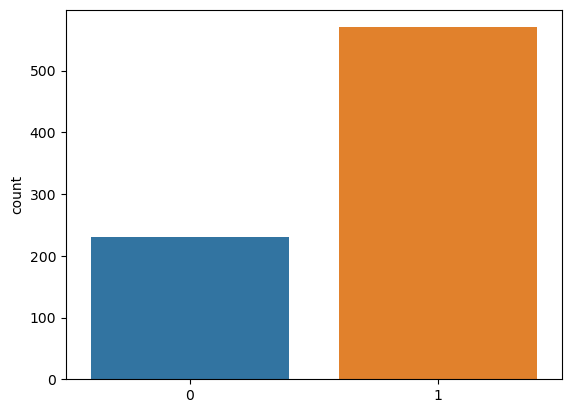

In [21]:
sns.countplot(x=y_train)

### Predicción con modelo base y evaluación de calidad: MAE, MSE, RMSE, Accuracy, Precision, Recall y F1



In [22]:
y_pred = (pipe.predict(X_test) > 0.5).astype("int32")
y_pred=y_pred.flatten()# de 2D a 1D

7/7 [==============================] - 0s 2ms/step


In [23]:
dataframeFinal=pd.DataFrame({'real':y_test, 'predicción': y_pred})

np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})

dataframeFinal.head(20)

,real,predicción
0,1,1
1,1,1
2,1,1
3,0,1
4,1,1
5,1,1
6,1,1
7,0,1
8,1,1
9,1,1


In [24]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
accuracy=str(accuracy_score(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)  
print('Mean Squared Error (MSE):', MSE)  
print('Root Mean Squared Error (RMSE):', RMSE) 
print('Accuracy: ' + accuracy) 

print('Confusion_matrix:')
y_test_transformado = y_test
y_pred_transformado = y_pred

cm = confusion_matrix(y_test_transformado, y_pred_transformado)  
print(cm)  
tn, fp, fn, tp = confusion_matrix(y_test_transformado, y_pred_transformado).ravel()  
print(tn,fp,fn,tp)

precision=precision_score(y_test_transformado, y_pred_transformado)
precision=str(round(precision, 4))
print('Precision:',precision)

recall=recall_score(y_test_transformado, y_pred_transformado)
recall=str(round(recall, 4))
print('Recall:',recall)

f1=f1_score(y_test_transformado, y_pred_transformado)
f1=str(round(f1, 4))
print('F1:',f1)

Mean Absolute Error (MAE): 0.28
Mean Squared Error (MSE): 0.28
Root Mean Squared Error (RMSE): 0.5292
Accuracy: 0.72
Confusion_matrix:
[[ 27  43]
 [ 13 117]]
27 43 13 117
Precision: 0.7312
Recall: 0.9
F1: 0.8069


## Fase 3: Optimización del modelo de red neuronal (Fine Tuning)

El proceso de Optimizacion consiste en reducir el error. Es decir, buscamos que la precision sea más alta. Mientras mayor es el accuracy será mejor el modelo de red neuronal para este problema.

El proceso de “Fine Tunning” consiste en buscar posibles errores, y combinaciones de parámetros que puedan mejorar el modelo. Este proceso consume mucha memoria RAM, por lo tanto es recomendable usar alguna nube con mejores recursos a los locales, como por ejemplo: Google Colab, Noteable, Azure Notebooks, Databricks, Amazon SageMaker, Deepnote, IBM Watson Studio, Paperspace Gradient, etc.

Estrategia de Optimización:

* Paso 1. Parámetros de compilación: batcha size, cantidad de epochs, optimizador

* Paso 2. Densidad de las capas de neuronas y regularización de Dropout

**Dropout:** basicamente lo que hace es apagar neuronas al azar con el fin de que las neuronas no se vuelvan tan dependientes de los datos, es decir que se entrenen mejor para evitar el overfitting, para ello importaremos nuestra capa de dropout. La capa dropout recibe como parámetro un numero entre 0 y 1 que representa el porcentaje de neuronas que se va a desactivar en esa capa.

Dicho de otra forma: durante el entrenamiento, en cada paso (epoch), se “apaga” o “desactiva” aleatoriamente un cierto porcentaje de neuronas en la red neuronal. Esto significa que, en lugar de que todas las neuronas participen en el cálculo de las salidas, solo una parte de ellas se activa en cada paso.

Con la técnica “GridSearchCV” podremos optimizar todos los parámetros.

**Consideraciones sobre el tamaño del lote (Batch Size):**

El tamaño del lote determina cuántos ejemplos de entrenamiento se utilizan para actualizar los pesos de la red en cada paso de entrenamiento. Un tamaño de lote más grande tiende a proporcionar estimaciones de gradiente más precisas, lo que puede llevar a un entrenamiento más rápido y estable.
Sin embargo, tamaños de lote más grandes requieren más memoria y pueden ralentizar el entrenamiento si no tienes recursos computacionales adecuados.
Un tamaño de lote pequeño puede ser útil para el entrenamiento en conjuntos de datos grandes o cuando la memoria es limitada, pero puede ser más ruidoso y converger más lentamente.

**Consideraciones sobre la densidad de neuronas:**

La densidad de neuronas se refiere al número de neuronas en cada capa de la red. Añadir más neuronas aumenta la capacidad de la red para aprender patrones complejos en los datos, pero también puede llevar al sobreajuste si se vuelve excesivo.
La elección de la densidad de neuronas depende de la complejidad de la tarea. En problemas simples, capas con menos neuronas pueden ser suficientes, mientras que en tareas complejas, puede ser necesario un mayor número de neuronas.
La optimización de la densidad de neuronas es una parte importante del diseño de la arquitectura de la red y a menudo implica pruebas y experimentación.
Estrategia general:

Es común comenzar con un tamaño de lote razonable y luego ajustarlo según la capacidad de la memoria y el tiempo de entrenamiento disponibles. Luego, diseñar la arquitectura de la red neuronal, incluida la densidad de neuronas, requiere una comprensión profunda de la naturaleza de la tarea y a menudo involucra experimentación para determinar la configuración óptima. En muchos casos, ambos aspectos se ajustan iterativamente para lograr un buen rendimiento en la tarea.

### Evaluación de modelo base: promedio de N experimentos